In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

# PLM Stability Functions

In [3]:
from transformers import AutoTokenizer, EsmForMaskedLM
import torch
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

In [5]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM

AMINO_ACIDS = list("ACDEFGHIKLMNPQRSTVWY")

TOKENIZER = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")
MODEL = AutoModelForMaskedLM.from_pretrained("facebook/esm2_t33_650M_UR50D")

In [6]:
!pip install --upgrade ipywidgets
!pip install widgetsnbextension pandas-profiling
!jupyter nbextension enable --py widgetsnbextension


  Using cached pandas_profiling-3.2.0-py2.py3-none-any.whl.metadata (21 kB)
  Using cached joblib-1.1.1-py2.py3-none-any.whl.metadata (5.2 kB)
  Using cached pydantic-2.11.1-py3-none-any.whl.metadata (63 kB)
  Using cached MarkupSafe-2.1.5.tar.gz (19 kB)
  Preparing metadata (setup.py) ... done
  Using cached visions-0.7.4-py3-none-any.whl.metadata (5.9 kB)
  Using cached htmlmin-0.1.12.tar.gz (19 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [19 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
          exec(compile('''
          ~~~~^^^^^^^^^^^^
          # This is <pip-setuptools-caller> -- a caller that pip uses to run setup.py
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
          ...<31 lines>...
          exec(compile(setup_py_code, filename, "exec"))
          ^^^^^^^

In [11]:
from tqdm.notebook import tqdm
import numpy as np

def generate_mutation_heatmap(sequence, start_pos=1, end_pos=None, save=False):
    input_ids = TOKENIZER.encode(sequence, return_tensors="pt")
    sequence_length = input_ids.shape[1] - 2

    if end_pos == None:
        end_pos = sequence_length

    heatmap = np.zeros((20, end_pos - start_pos + 1))

    for position in tqdm(range(start_pos, end_pos + 1), desc="Calculating Position PLL"):
        # mask target position
        masked_input_ids = input_ids.clone()
        masked_input_ids[0, position] = TOKENIZER.mask_token_id

        # get logits for when the target position is masked
        with torch.no_grad():
            logits = MODEL(masked_input_ids).logits

        # calc log probs
        probabilities = torch.nn.functional.softmax(logits[0, position], dim=0)
        log_probabilities = torch.log(probabilities)

        # get log prob of wild type residue
        wt_residue = input_ids[0, position].item()
        log_prob_wt = log_probabilities[wt_residue].item()

        for i, amino_acid in enumerate(AMINO_ACIDS):
            # get mutated log probability
            log_prob_mt = log_probabilities[TOKENIZER.convert_tokens_to_ids(amino_acid)].item()
            heatmap[i, position - start_pos] = log_prob_mt - log_prob_wt

        if save:
            np.save("sequence_mutation_heatmap.npy", heatmap)

    
    return heatmap

In [8]:
import matplotlib.pyplot as plt
def visualize_heatmap(heatmap, protein_sequence, start_pos, end_pos):
    # Visualize the heatmap
    plt.figure(figsize=(15, 5))
    plt.imshow(heatmap, cmap="viridis", aspect="auto")
    plt.xticks(range(end_pos - start_pos + 1), list(protein_sequence[start_pos-1:end_pos]))
    plt.yticks(range(20), AMINO_ACIDS)
    plt.xlabel("Position in Protein Sequence")
    plt.ylabel("Amino Acid Mutations")
    plt.title("Predicted Effects of Mutations on Protein Sequence (LLR)")
    plt.colorbar(label="Log Likelihood Ratio (LLR)")
    plt.show()

# Running on Original Sequence


In [12]:
# get the sequence
seq = open('../sequence.fasta', 'r').read()
seq = seq.split("\n")[1]
print(seq)

MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP


In [13]:
heatmap = generate_mutation_heatmap(seq, start_pos=1, end_pos=None, save=True)
np.save("sequence_mutation_heatmap.npy", heatmap)

Calculating Position PLL:   0%|          | 0/656 [00:00<?, ?it/s]

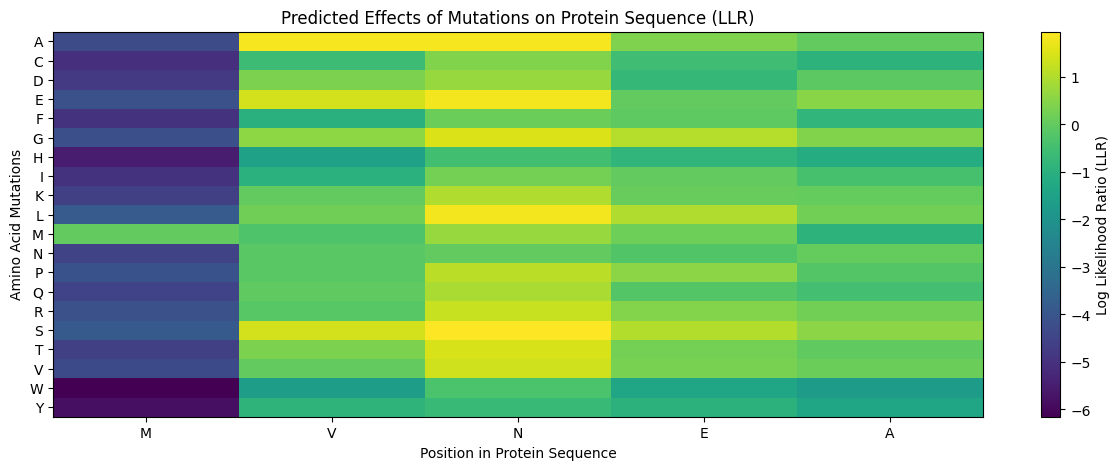

In [24]:
visualize_heatmap(heatmap, protein_sequence=seq, start_pos=1, end_pos=5)

# Comparing Training Test

In [ ]:
v